# Basic imports

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

pd.set_option("display.max_columns", None)

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [64]:
!pip install torchtyping
from torchtyping import TensorType

# Data preparation

## Download Apple's stock prices dataset

In [65]:
apple_stocks = yf.download("AAPL", period="max")

[*********************100%***********************]  1 of 1 completed


In [66]:
apple_stocks.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600


In [67]:
apple_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11021 entries, 1980-12-12 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       11021 non-null  float64
 1   High       11021 non-null  float64
 2   Low        11021 non-null  float64
 3   Close      11021 non-null  float64
 4   Adj Close  11021 non-null  float64
 5   Volume     11021 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 602.7 KB


## Get rid of unnecessary columns

In [68]:
data = pd.DataFrame(apple_stocks['Close'])
data.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


## Plot the `Close` prices

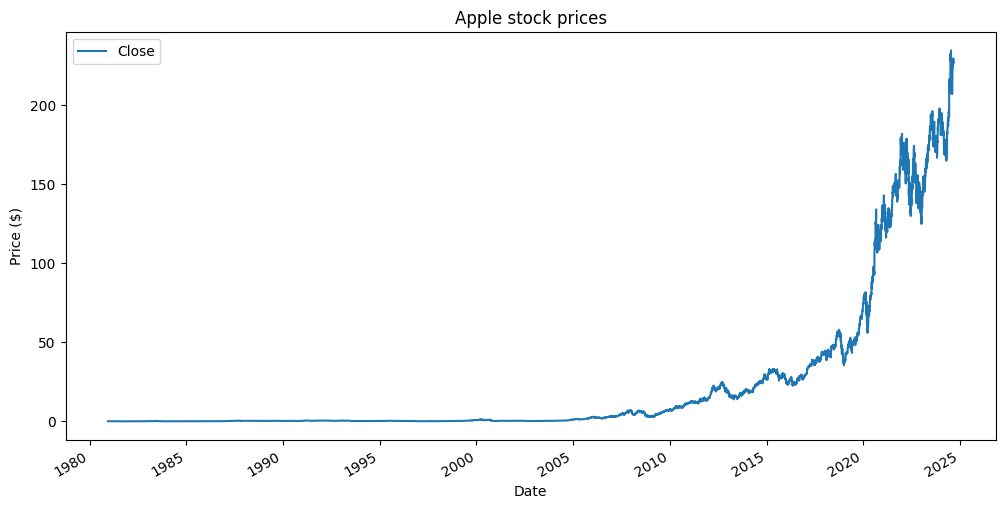

In [69]:
ax = data.plot(figsize=(12, 6), title="Apple stock prices")
ax.set_ylabel("Price ($)")
plt.show()

## Add lagged features

In [70]:
def create_lagged_features(df: pd.DataFrame, feature_name: str, n_features: int) -> pd.DataFrame:
    """
    Generate lagged features for a specified column in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the time series data.
        feature_name (str): The name of the column for which to create lagged features.
        n_features (int): Number of lagged features to create.

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for each lagged feature,
                      named '{feature_name}(t - 1)', '{feature_name}(t - 2)', ..., up to '{feature_name}(t - n)'.
    """
    df = df.copy()

    for i in range(n_features):
        df[f'{feature_name}(t - {i + 1})'] = df[feature_name].shift((i + 1))

    return df

In [71]:
SEQUENCE_LEN = 7

In [72]:
data = create_lagged_features(data, feature_name="Close", n_features=SEQUENCE_LEN)
data.dropna().head(SEQUENCE_LEN + 1)

,Close,Close(t - 1),Close(t - 2),Close(t - 3),Close(t - 4),Close(t - 5),Close(t - 6),Close(t - 7)
Date,,,,,,,,
1980-12-23,0.137835,0.132254,0.126116,0.118862,0.115513,0.112723,0.121652,0.128348
1980-12-24,0.145089,0.137835,0.132254,0.126116,0.118862,0.115513,0.112723,0.121652
1980-12-26,0.158482,0.145089,0.137835,0.132254,0.126116,0.118862,0.115513,0.112723
1980-12-29,0.160714,0.158482,0.145089,0.137835,0.132254,0.126116,0.118862,0.115513
1980-12-30,0.156808,0.160714,0.158482,0.145089,0.137835,0.132254,0.126116,0.118862
1980-12-31,0.152344,0.156808,0.160714,0.158482,0.145089,0.137835,0.132254,0.126116
1981-01-02,0.154018,0.152344,0.156808,0.160714,0.158482,0.145089,0.137835,0.132254
1981-01-05,0.150670,0.154018,0.152344,0.156808,0.160714,0.158482,0.145089,0.137835


## Get rid of stock prices before 2005-01-01 as their value stayed almost the same

In [73]:
data = data.loc['2005-01-01':]

## Scale the data

In [74]:
scaler = MinMaxScaler()

columns = data.columns.to_list()

scaled_data = scaler.fit_transform(data)

for i, column in enumerate(columns):
    data[column] = scaled_data[:, i]

data.head()

,Close,Close(t - 1),Close(t - 2),Close(t - 3),Close(t - 4),Close(t - 5),Close(t - 6),Close(t - 7)
Date,,,,,,,,
2005-01-03,0.000000,0.000085,0.000115,0.000088,0.000068,0.000000,0.000065,0.000045
2005-01-04,0.000050,0.000000,0.000085,0.000115,0.000088,0.000078,0.000000,0.000065
2005-01-05,0.000092,0.000050,0.000000,0.000085,0.000115,0.000098,0.000078,0.000000
2005-01-06,0.000096,0.000092,0.000050,0.000000,0.000085,0.000125,0.000098,0.000078
2005-01-07,0.000455,0.000096,0.000092,0.000050,0.000000,0.000095,0.000125,0.000098


## Plot the final data

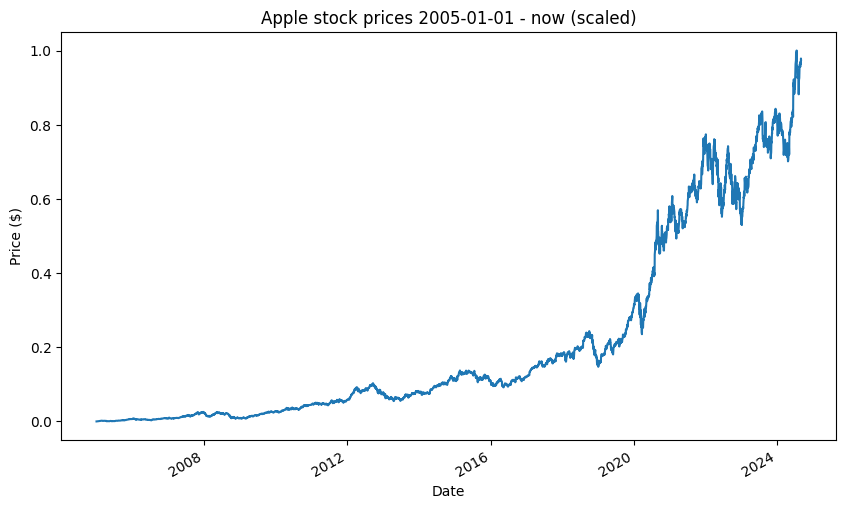

In [75]:
ax = data['Close'].plot(figsize=(10, 6), title="Apple stock prices 2005-01-01 - now (scaled)")
ax.set_ylabel("Price ($)")
plt.show()

## Split the data into X and y

In [76]:
FEATURES = [f'Close(t - {i + 1})' for i in range(SEQUENCE_LEN)]
TARGET = 'Close'

In [77]:
X = data[FEATURES]
y = data[TARGET]

## Converting the data to `torch.Tensor`'s

In [78]:
X = torch.tensor(X.to_numpy()).float()
y = torch.tensor(y.to_numpy()).float()
X.shape, y.shape

(torch.Size([4949, 7]), torch.Size([4949]))

## Reshaping X into (N, L, H_in) and y into (N, H_out)

In [79]:
X = X.reshape((-1, SEQUENCE_LEN, 1))
y = y.reshape(-1, 1)
X.shape, y.shape

(torch.Size([4949, 7, 1]), torch.Size([4949, 1]))

## Split the data into train and test

In [80]:
# leave 182 days for testing
TEST_LEN = 182
SPLIT_INDEX = len(X) - TEST_LEN

X_train, X_test, y_train, y_test = X[:SPLIT_INDEX], X[SPLIT_INDEX:], y[:SPLIT_INDEX], y[SPLIT_INDEX:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4767, 7, 1]),
 torch.Size([182, 7, 1]),
 torch.Size([4767, 1]),
 torch.Size([182, 1]))

## Convert the data into `TensorDataset`'s and create `DataLoader`'s

In [81]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

BATCH_SIZE = 16

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

sample_X, sample_y = next(iter(train_dataloader))
sample_X[0], sample_y[0]

(tensor([[0.0694],
         [0.0718],
         [0.0747],
         [0.0752],
         [0.0742],
         [0.0755],
         [0.0752]]),
 tensor([0.0725]))

# Create LSTM model

## Define the LSTM class

In [82]:
class LSTM(nn.Module):
    """
    A simple LSTM model for sequence prediction.

    Args:
        n_input (int): The number of input features.
        n_hidden (int): The number of hidden units in the LSTM layer.
        n_layers (int): The number of LSTM layers stacked on top of each other.

    Attributes:
        lstm (nn.LSTM): The LSTM layer.
        l1 (nn.Linear): The linear layer that produces the final output.

    Methods:
        forward(X: TensorType[torch.float32]) -> TensorType[torch.float32]:
            Passes the input tensor through the LSTM layer and the subsequent linear layer to produce the output.
    """
    def __init__(self, n_input: int, n_hidden: int, n_layers: int) -> None:
        """
        Initializes the LSTM model with specified input features, hidden units, and layers.

        Args:
            n_input (int): Number of input features.
            n_hidden (int): Number of hidden units in the LSTM layer.
            n_layers (int): Number of LSTM layers.
        """
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=0.2)
        self.l1 = nn.Linear(n_hidden, 1)

    def forward(self, X: TensorType[torch.float32]) -> TensorType[torch.float32]:
        """
        Defines the forward pass of the LSTM model.

        Args:
            X (TensorType[torch.float32]): Input tensor with shape (batch_size, seq_length, n_input).

        Returns:
            TensorType[torch.float32]: Output tensor with shape (batch_size, 1).
        """
        output, _ = self.lstm(X)
        output = self.l1(output[:, -1, :])
        return output

In [83]:
model = LSTM(1, 128, 5).to(device)
model

LSTM(
  (lstm): LSTM(1, 128, num_layers=5, batch_first=True, dropout=0.2)
  (l1): Linear(in_features=128, out_features=1, bias=True)
)

## Define loss function and optimizer

In [84]:
LEARNING_RATE = 1e-4

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train the model

In [85]:
def train_epoch(dataloader: DataLoader, optimizer: optim.Optimizer, loss_fn: nn.modules.loss._Loss) -> None:
    """
    Trains a model for one epoch using the provided dataloader, optimizer, and loss function.

    This function iterates over the training data in batches, computes the loss, performs backpropagation,
    and updates the model's weights using the optimizer. It also tracks and prints the current and average loss
    after every 10 batches.

    Args:
        dataloader (DataLoader): The DataLoader providing the training data in batches.
        optimizer (optim.Optimizer): The optimizer used to update the model's weights.
        loss_fn (nn.modules.loss._Loss): The loss function used to compute the difference between predictions and targets.

    Returns:
        None
    """
    avg_loss = 0.0

    model.train()
    for batch_index, (X, y) in enumerate(train_dataloader, 1):
        X, y = X.to(device), y.to(device)

        prediction = model(X)
        loss = loss_fn(prediction, y)

        avg_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            loss = loss.item()
            current_sample = batch_index * len(X)

            print(f'Current loss: {loss:.5f}, Average loss: {avg_loss / 10:.5f} [{current_sample} / {len(dataloader.dataset)}]')
            avg_loss = 0.0

In [86]:
def test_epoch(dataloader: DataLoader, loss_fn: nn.modules.loss._Loss) -> None:
    """
    Evaluates the model's performance on the test dataset for one epoch.

    This function iterates over the test data, computes the loss for each batch, and
    calculates the average loss across all batches. The model is set to evaluation mode
    to disable dropout and other training-specific behaviors.

    Args:
        dataloader (DataLoader): The DataLoader providing the test data in batches.
        loss_fn (nn.modules.loss._Loss): The loss function used to compute the difference between predictions and targets.

    Returns:
        None
    """
    model.eval()

    avg_test_loss = 0.0

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            prediction = model(X)

            loss = loss_fn(prediction, y)
            avg_test_loss += loss.item()

    print(f'Average test loss: {avg_test_loss / len(test_data):.5f}')

In [87]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    print(f"|--------------------------{epoch + 1}/{N_EPOCHS}--------------------------|")
    train_epoch(train_dataloader, optimizer, loss_fn)
    test_epoch(test_dataloader, loss_fn)



|--------------------------1/5--------------------------|
Current loss: 0.02016, Average loss: 0.09916 [160 / 4767]
Current loss: 0.07900, Average loss: 0.07986 [320 / 4767]
Current loss: 0.03752, Average loss: 0.05857 [480 / 4767]
Current loss: 0.07062, Average loss: 0.05218 [640 / 4767]
Current loss: 0.02938, Average loss: 0.05697 [800 / 4767]
Current loss: 0.06498, Average loss: 0.04162 [960 / 4767]
Current loss: 0.04462, Average loss: 0.04854 [1120 / 4767]
Current loss: 0.05421, Average loss: 0.05724 [1280 / 4767]
Current loss: 0.05649, Average loss: 0.04577 [1440 / 4767]
Current loss: 0.03627, Average loss: 0.05118 [1600 / 4767]
Current loss: 0.06559, Average loss: 0.05235 [1760 / 4767]
Current loss: 0.12471, Average loss: 0.05432 [1920 / 4767]
Current loss: 0.04854, Average loss: 0.04882 [2080 / 4767]
Current loss: 0.03537, Average loss: 0.03917 [2240 / 4767]
Current loss: 0.05180, Average loss: 0.04842 [2400 / 4767]
Current loss: 0.03721, Average loss: 0.03419 [2560 / 4767]
Curr

## Test the model

In [88]:
test_data = pd.DataFrame(data.iloc[SPLIT_INDEX:]['Close'])
test_data = test_data.rename(columns={'Close': 'Actual'})

In [89]:
model.eval()
with torch.no_grad():
    predicted_test_data = model(X_test.to(device))

## Predicting "the future"

In [90]:
predicted_future = torch.zeros((TEST_LEN + SEQUENCE_LEN, 1))
predicted_future[:SEQUENCE_LEN] = X_test[0]

model.eval()
with torch.no_grad():
    for i in range(TEST_LEN):
        x = predicted_future[i:i + SEQUENCE_LEN].view(1, -1, 1) # (N, L, H_in) shape
        y = model(x.to(device))
        predicted_future[SEQUENCE_LEN + i] = y.cpu()

predicted_future = predicted_future[7:]

## Undo the scaling

In [91]:
predicted_test_data = predicted_test_data.cpu().numpy() - scaler.min_[0]
predicted_test_data /= scaler.scale_[0]

predicted_future = predicted_future.cpu().numpy() - scaler.min_[0]
predicted_future /= scaler.scale_[0]

actual = test_data['Actual'].to_numpy() - scaler.min_[0]
actual /= scaler.scale_[0]

In [92]:
test_data['Predicted_test_data'] = predicted_test_data
test_data['Predicted_future_data'] = predicted_future
test_data['Actual'] = actual
test_data.head()

,Actual,Predicted_test_data,Predicted_future_data
Date,,,
2023-12-11,193.179993,182.019989,182.019989
2023-12-12,194.710007,181.886292,181.280838
2023-12-13,197.960007,182.063751,180.618042
2023-12-14,198.110001,182.925201,180.153931
2023-12-15,197.570007,183.566330,178.924713


- `predicted_future_data` are prices predicted based on model's previous predictions
- `predicted_test_data` are prices predicted based on actual values in the past

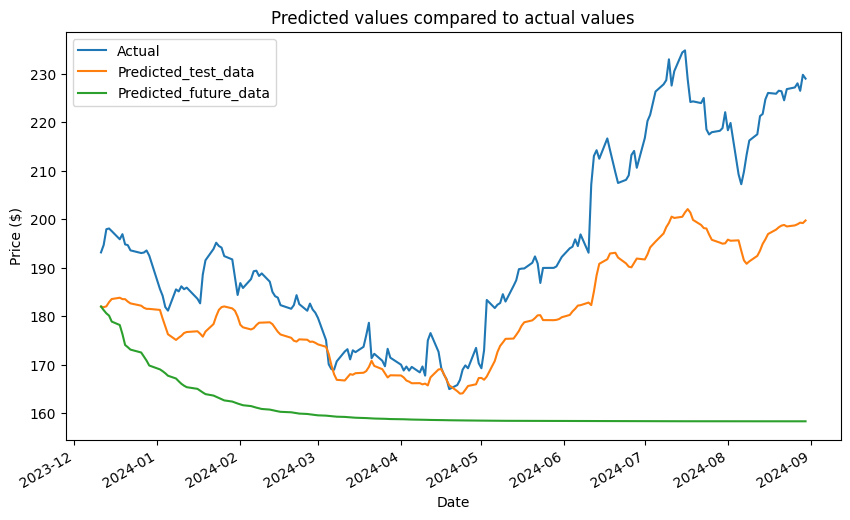

In [93]:
ax = test_data.plot(figsize=(10, 6), title="Predicted values compared to actual values")
ax.set_ylabel("Price ($)")
plt.show()